In [51]:
import os
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [52]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

# Loading Data

In [53]:
def parse_structure_names(DATA_PATH=DATA_DIR):
    structure_names = []
    for filename in os.listdir(DATA_DIR):
        ext = ".json"
        if filename.endswith(ext):
            structure_names.append(filename[: -len(ext)])
            
    return structure_names

In [54]:
structure_names = ["Ge-1_Se-1", "Ge-1_Te-1", "Ge-1_Sb-1", "Si-1_C-1"]
encoding = "column"

In [55]:
df = pd.concat([pd.read_csv(os.path.join(DATA_DIR, f"{struct_name}_{encoding}.csv"), index_col=0) for struct_name in structure_names], ignore_index=True)

In [56]:
cols_raw = list(df.columns)
cols_trash = ['converged', 'accuracy']
cols_independent = ['delta_E']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [57]:
X_raw = df[cols_dependent]
y_raw = np.abs(df[cols_independent]).squeeze()

In [58]:
X_raw.describe()

ecutrho    k_density      ecutwfc    PTC1    PTC2    PTC3    PTC4  \
count  2547.000000  2547.000000  2547.000000  2547.0  2547.0  2547.0  2547.0   
mean    243.133098     5.977228    57.764036     0.0     0.0     0.0     0.0   
std      89.762272     2.828613    23.596846     0.0     0.0     0.0     0.0   
min     100.000000     2.000000    20.000000     0.0     0.0     0.0     0.0   
25%     180.000000     4.000000    35.000000     0.0     0.0     0.0     0.0   
50%     260.000000     6.000000    55.000000     0.0     0.0     0.0     0.0   
75%     340.000000     8.000000    75.000000     0.0     0.0     0.0     0.0   
max     380.000000    10.000000   100.000000     0.0     0.0     0.0     0.0   

         PTC5    PTC6    PTC7  ...    PTC9   PTC10   PTC11   PTC12   PTC13  \
count  2547.0  2547.0  2547.0  ...  2547.0  2547.0  2547.0  2547.0  2547.0   
mean      0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
std       0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
min       0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
25%       0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
50%       0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
75%       0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
max       0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   

        PTC14        PTC15        PTC16   PTC17   PTC18  
count  2547.0  2547.000000  2547.000000  2547.0  2547.0  
mean      0.5     0.130153     0.242442     0.0     0.0  
std       0.0     0.219444     0.249935     0.0     0.0  
min       0.5     0.000000     0.000000     0.0     0.0  
25%       0.5     0.000000     0.000000     0.0     0.0  
50%       0.5     0.000000     0.000000     0.0     0.0  
75%       0.5     0.500000     0.500000     0.0     0.0  
max       0.5     0.500000     0.500000     0.0     0.0  

[8 rows x 21 columns]

# Train-Test-Split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [60]:
# functions such that f(x) != 0 and f(+inf) = 0
functions_set_1 = [
    lambda x: np.exp(-x),
    lambda x: 1 / (1+x),
    lambda x: 1 / (1+x)**2,
    lambda x: np.cos(x) * np.exp(-x),
]

# functions such that f(x) = 0 and f(+inf) = 0
functions_set_2 = [
    lambda x: x*np.exp(-x),
    lambda x: x / (1+x)**2,
    lambda x: x / (1+x)**3,
    lambda x: np.sin(x) * np.exp(-x),
]

linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', FeatureUnion(
    [
        (f"fun_{j}", FunctionTransformer(lambda X : f(X[:,:3]))) for j, f in enumerate(functions_set_1 + functions_set_2)
    ] + [
        (f"fun_{j}_col_{col}_1", FunctionTransformer(lambda X : f(X[:,:3] * X[:,i][:, None]))) for j, f in enumerate(functions_set_1) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ] + [
        (f"fun_{j}_col_{col}_2", FunctionTransformer(lambda X : f(X[:,3:] * X[:,i][:, None]))) for j, f in enumerate(functions_set_2) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ])),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [61]:
rf_model = RandomForestRegressor(random_state=0)

### Gradient Boosting

In [62]:
gb_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [63]:
xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### Packing them together to reduce code size

In [64]:
models = {
    "Augmented Linear Regression": linear_augmented_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [ ]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...
Done!

Training Gradient Boosting...


# Model evaluation

In [ ]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression...
MSE:	train:1.9073E-02	test:1.9850E-02
MAPE:	train:3.5669E+11	test:5.1835E+11
Done!

Evaluating Random Forest...
MSE:	train:1.9444E-06	test:3.8695E-06
MAPE:	train:1.3451E+08	test:1.6660E+09
Done!

Evaluating Gradient Boosting...
MSE:	train:2.4273E-06	test:3.0846E-06
MAPE:	train:7.0835E+08	test:2.2560E+09
Done!

Evaluating XGBoost...
MSE:	train:2.0110E-06	test:2.8219E-06
MAPE:	train:1.9354E+09	test:2.6033E+09
Done!



# Visualization

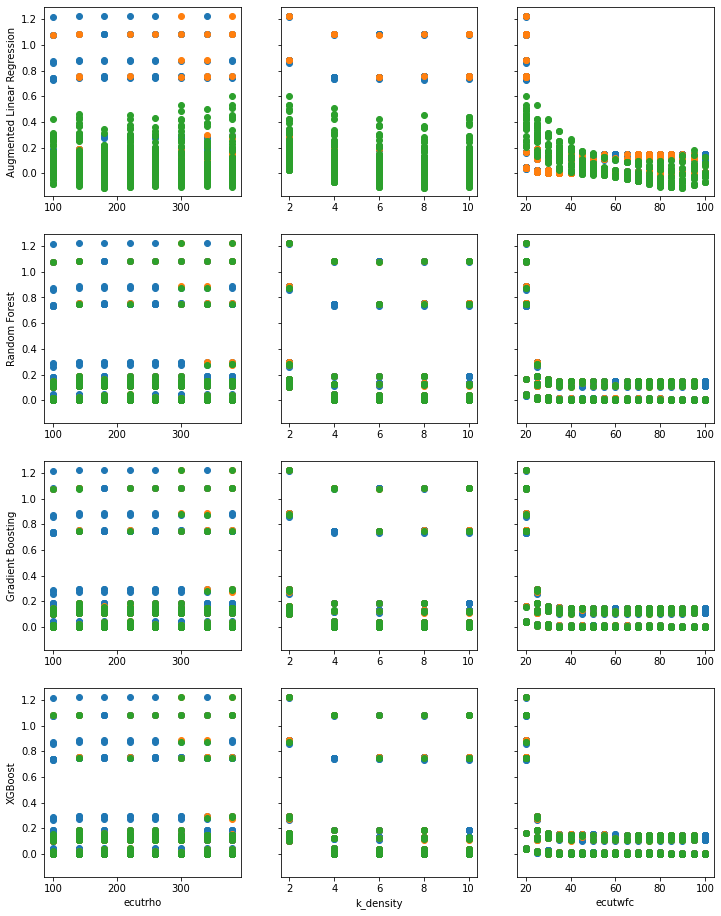

In [ ]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')
PLOTPATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "plots/delta_E_regression/toy_comparison.png")
plt.savefig(PLOTPATH)

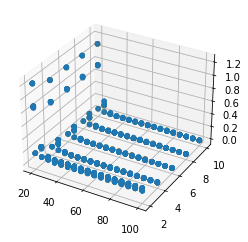

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))

## Predict $\log(\Delta E)$ instead of $∆E$

In [18]:
def log_transform(y, miny, eps=10E-15):
    return np.log(y - miny + eps)

def inv_log_transform(logy, miny, eps=10E-15):
    return np.exp(logy) + miny - eps

miny = float(np.min(y_raw))
maxy = float(np.max(y_raw))

y_raw_s = np.array(y_raw.squeeze())
miny2 = np.sort(list(set(list(y_raw_s))))[1]
eps = (miny2 - miny)/10

    

logy_raw = log_transform(y_raw, miny, eps)
X_train, X_test, logy_train, logy_test = train_test_split(
    X_raw, logy_raw,
    test_size=0.2,
    random_state=42
)

In [19]:
linear_log_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

In [20]:
rf_log_model = RandomForestRegressor()

In [21]:
gb_log_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

In [22]:
xgb_log_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

In [23]:
models = {
    "Augmented Linear Regression - Log": linear_log_augmented_model,
    "Random Forest - Log": rf_log_model,
    "Gradient Boosting - Log": gb_log_model,
    "XGBoost - Log": xgb_log_model,
}

In [24]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, logy_train)
    print("Done!\n")

Training Augmented Linear Regression - Log...
Done!

Training Random Forest - Log...
Done!

Training Gradient Boosting - Log...
Done!

Training XGBoost - Log...
Done!



In [25]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    logy_pred_train = model.predict(X_train)
    y_pred_train = inv_log_transform(logy_pred_train.squeeze(), miny, eps)
    logy_pred_test = model.predict(X_test)
    y_pred_test = inv_log_transform(logy_pred_test.squeeze(), miny, eps)
    
    y_train = inv_log_transform(logy_train.squeeze(), miny, eps)
    y_test = inv_log_transform(logy_test.squeeze(), miny, eps)

    mse_test = mean_squared_error(logy_test, logy_pred_test)
    mse_train = mean_squared_error(logy_train, logy_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(logy_test, logy_pred_test)
    mape_train = mean_absolute_percentage_error(logy_train, logy_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression - Log...
MSE:	train:2.3108E+00	test:2.5180E+00
MSE:	train:3.1412E-02	test:3.3510E-02
MAPE:	train:7.2494E-01	test:6.6516E-01
Done!

Evaluating Random Forest - Log...
MSE:	train:2.2951E-01	test:8.1013E-01
MSE:	train:2.4304E-05	test:1.2842E-04
MAPE:	train:2.9998E-02	test:5.4973E-02
Done!

Evaluating Gradient Boosting - Log...
MSE:	train:3.4984E-01	test:6.3043E-01
MSE:	train:1.3265E-03	test:3.6034E-04
MAPE:	train:9.3282E-02	test:9.1698E-02
Done!

Evaluating XGBoost - Log...
MSE:	train:2.0027E-01	test:9.8502E-01
MSE:	train:4.7977E-06	test:1.9027E-04
MAPE:	train:2.8416E-02	test:7.2969E-02
Done!



Text(0.5, 0, 'ecutwfc')

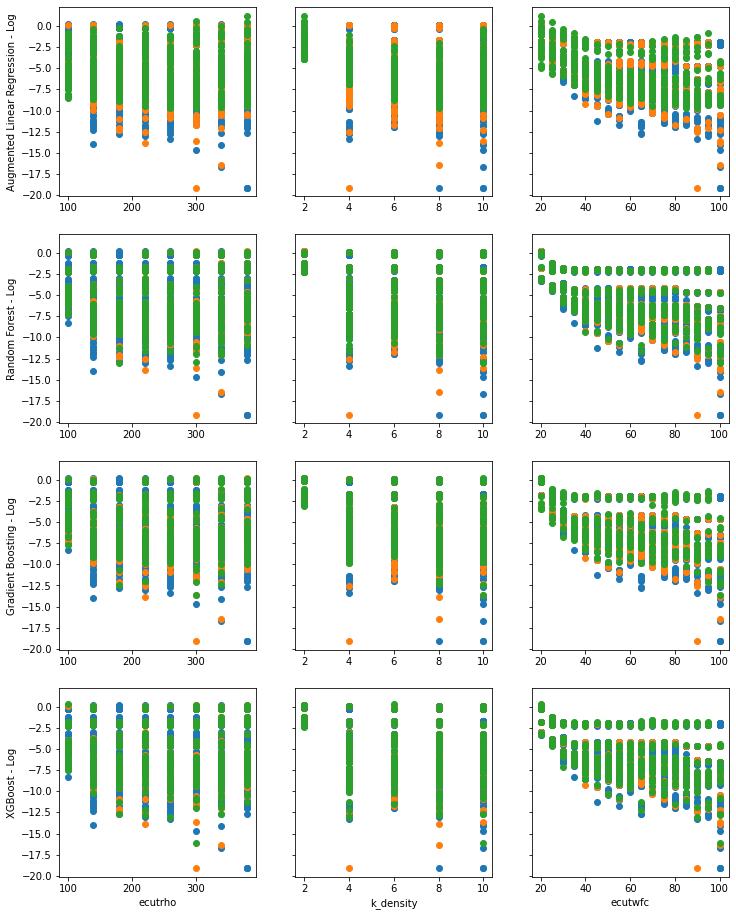

In [26]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], logy_train)
        ax[j,i].scatter(X_test[col], logy_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

# Find best parameters for a given error

In [70]:
from scipy.optimize import NonlinearConstraint, LinearConstraint, minimize, shgo, differential_evolution

In [31]:
def sanitize_input(x):
    return np.array([int(round(x_i)) for x_i in x])

def delta_E_prediction(x, model, structure_encoding):
    input = np.concatenate([x, structure_encoding])
    input = pd.DataFrame(input.reshape(1, -1), columns=X_raw.columns)
    return model.predict(input)[0]

def complexity(x):
    # we have to get the right formula for the complexity
    ecutrho = x[0]
    k_density = x[1]
    ecutwfc = x[2]
    return ecutrho + k_density + ecutwfc

In [32]:
# Compute GeTe structure encoding
if encoding == "atomic":
    Ge_idx = X_raw.columns.get_loc("Ge")
    Te_idx = X_raw.columns.get_loc("Te")
else:
    Ge_idx = X_raw.columns.get_loc("PTC14")
    Te_idx = X_raw.columns.get_loc("PTC16")
GeTe_encoding = np.zeros(X_raw.shape[1]-3)
GeTe_encoding[Ge_idx-3] = 0.5
GeTe_encoding[Te_idx-3] = 0.5

### Minimize complexity using $\Delta E$ regressors

In [34]:
x_0 = [100, 10, 100]
max_delta_E = 1e-3
model = xgb_model
model_pred_func = lambda x: delta_E_prediction(x, model, GeTe_encoding)

nonlin_constraint = NonlinearConstraint(lambda x: delta_E_prediction(x, model), 0, max_delta_E)
# lin_constraint = LinearConstraint(A=np.eye(3), lb=np.array([1,0,1]), ub=np.array([1000,0.5,1000]))

print(model_pred_func(x_0))

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[(1,1000), (1, 10), (1,1000)],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(model_pred_func(res.x))

# codes below don't work

# minimize(complexity, x_0, constraints=[nonlin_constraint, lin_constraint])

# res = minimize(complexity, x0=x_0, bounds=[(1,1000), (1e-16,0.5), (1,1000)],
#     constraints=({'type': 'ineq', 'fun': lambda x: delta_E_prediction(x, model)},
#                  {'type': 'ineq', 'fun': lambda x: -delta_E_prediction(x, model) + max_delta_E}),
#     options={'maxiter': 1000},
# )


0.012252152
     fun: 160.73504990898232
 message: 'Optimization terminated successfully.'
    nfev: 1497
     nit: 32
 success: True
       x: array([120.05954446,   3.10247035,  37.5730351 ])
[120   3  38]
0.00080123544


### Minimize complexity using $log(\Delta E)$ regressors

In [35]:
max_delta_E = 1e-5
model_log = xgb_log_model
model_log_pred_func = lambda x: inv_log_transform(delta_E_prediction(x, model_log, GeTe_encoding), miny, eps)

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_log_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[(1,1000), (1, 10), (1,1000)],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(model_log_pred_func(res.x))

     fun: 306.9471482513785
 message: 'Optimization terminated successfully.'
    nfev: 1632
     nit: 35
 success: True
       x: array([200.24604302,   9.19639564,  97.5047096 ])
[200   9  98]
7.547999700818764e-06


### Compare predicted parameters to the ones in datasets

In [38]:
from sklearn.neighbors import NearestNeighbors

In [102]:
def find_neighbors(X, y, params, structure_encoding):
    n_params = len(params)

    # get all rows with the same structure
    mask_same_struct = (X.values[:,n_params:] == structure_encoding).all(axis=1)
    df_same_struct = X.iloc[mask_same_struct,:n_params]
    y_same_struct = y[mask_same_struct]

    # noramlize the dataset in order to put the same importance to all parameters
    min_df, max_df = df_same_struct.min(), df_same_struct.max()
    df_same_struct = (df_same_struct - min_df) / (max_df - min_df)
    params = (params - min_df) / (max_df - min_df)

    knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
    knn.fit(df_same_struct)
    dist, idx = knn.kneighbors([params], 10)
    list_dist_delta_E = [*zip(dist[0], list(y_same_struct.iloc[idx[0]]))]
    return pd.DataFrame(list_dist_delta_E, columns=["dist", "delta_E"])

In [103]:
find_neighbors(X_raw, y_raw, sanitize_input(res.x), GeTe_encoding)

,dist,delta_E
0,0.146123,0.000020
1,0.146123,0.000008
2,0.146123,0.000013
3,0.146123,0.000014
4,0.148773,0.000135
5,0.148773,0.000164
6,0.148773,0.000170
7,0.148773,0.000142
8,0.175291,0.000313
9,0.175291,0.001874
